# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense

# Prepare the data

In [2]:
data = pd.read_csv("../collected_data/prepared_data/prestep_data.csv")

array([[<AxesSubplot: title={'center': 'vertices'}>,
        <AxesSubplot: title={'center': 'redexes'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'heights'}>],
       [<AxesSubplot: title={'center': 'widths'}>,
        <AxesSubplot: title={'center': 'steps_time'}>]], dtype=object)

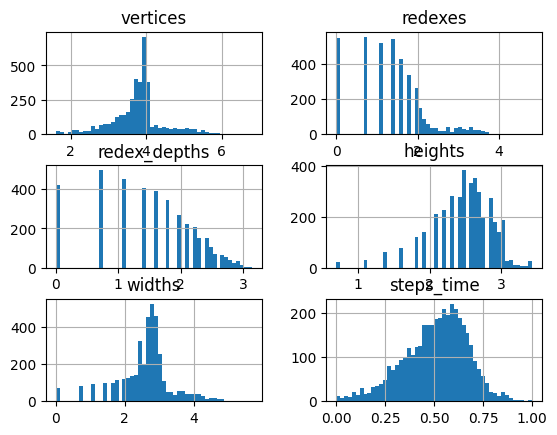

In [3]:
power_trans = PowerTransformer(method='yeo-johnson')

data_norm = pd.DataFrame()
for col_name in ["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time"]:
    norm_col_data = np.log(data[col_name])
    data_norm[col_name] = norm_col_data

mms = MinMaxScaler(feature_range=(0, 1))
data_norm["steps_time"] = mms.fit_transform(np.array(data_norm['steps_time']).reshape(-1, 1))

data_norm.hist(bins=50)

In [4]:
data_for_training = data_norm

In [5]:
def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2798
Examples for testing 1133


In [6]:
x_train, y_train = train_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], train_ds[["steps_time"]]
x_test, y_test = test_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], test_ds[["steps_time"]]
x_data, y_data = data_for_training[["vertices", "redexes", "redex_depths", "heights", "widths"]], data_for_training[
    ["steps_time"]]

# Train the Linear Regression

In [7]:
rcParams['figure.figsize'] = 10, 9


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

TRAIN Root Mean Squared Error(RMSE): 0.04506460891780832
TEST Root Mean Squared Error(RMSE): 0.04716619562893551


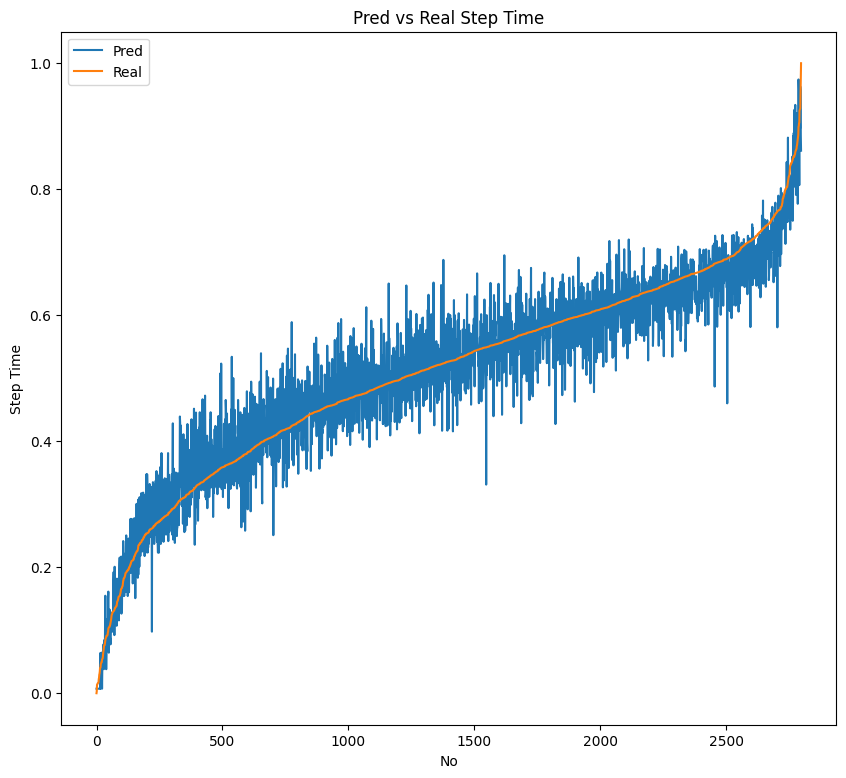

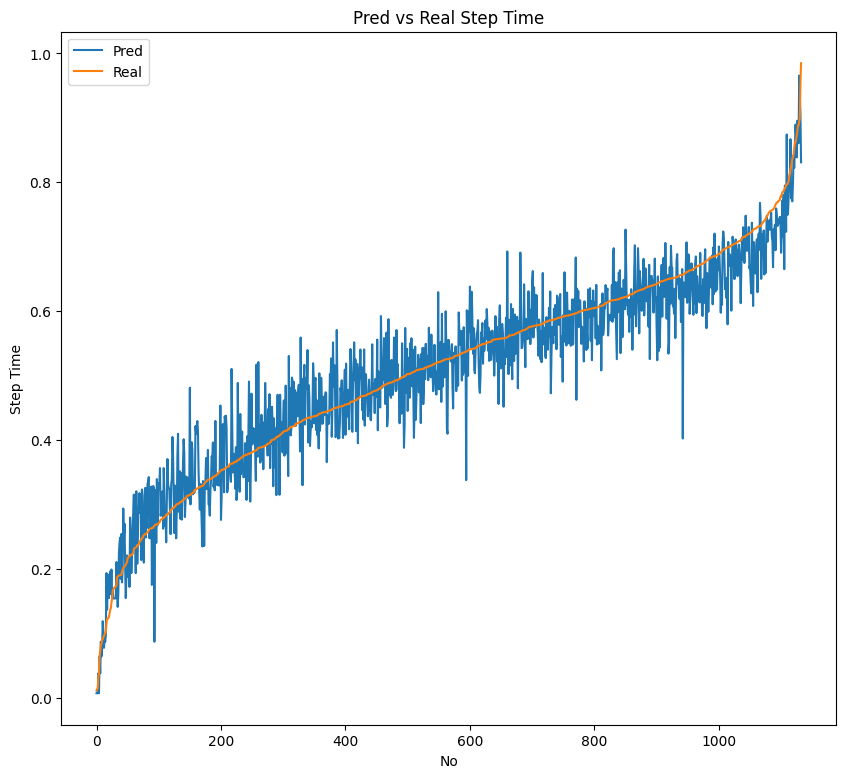

In [8]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

ALL RMSE: 0.04567305371326707


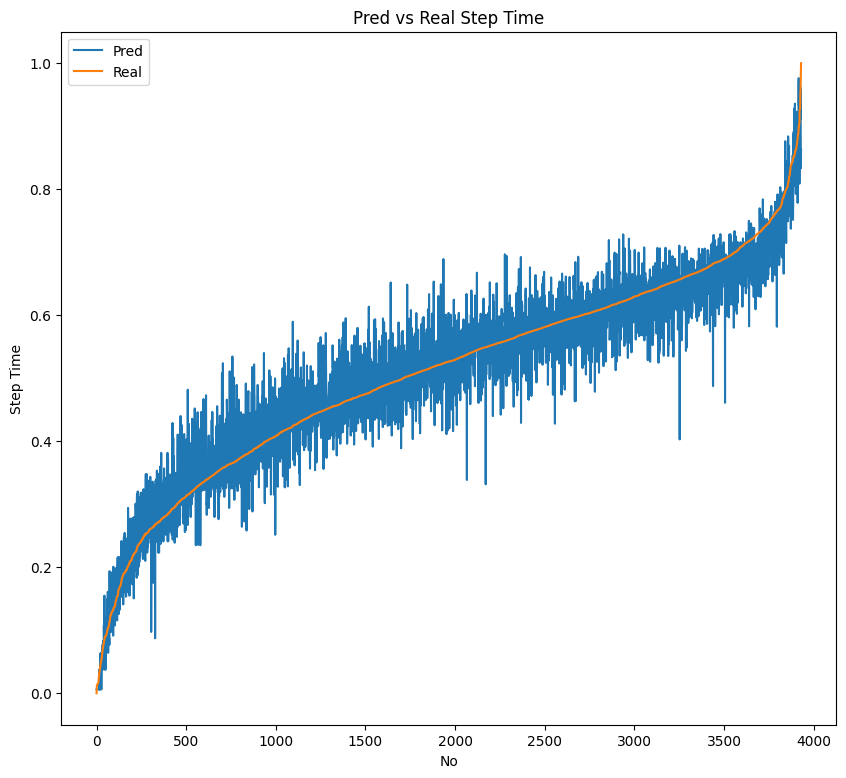

In [9]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

# Train the ANN Regression

In [10]:
model = Sequential()
model.add(Dense(units=30, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2798/2798 [==============================] - 4s 1ms/step - loss: 0.0310 - val_loss: 0.0053
Epoch 2/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 3/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 5/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 8/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 9/100
2798/2798 [==============================] - 3s 1ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/100
2798/2798 [==============================] - 3s 1ms/step - l

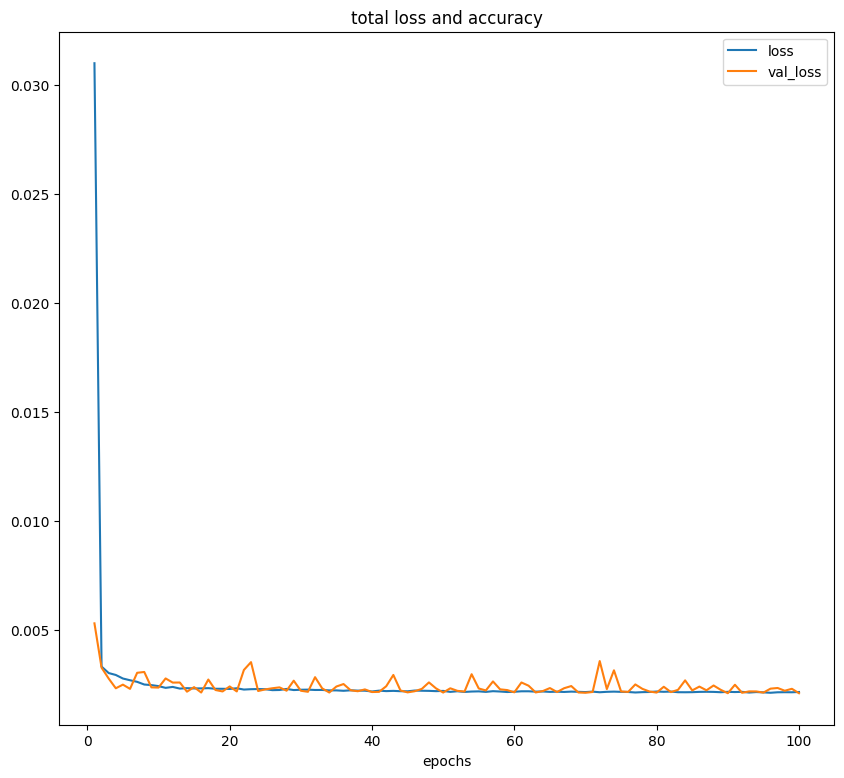

In [11]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [12]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

123/123 [==============================] - 0s 797us/step


TRAIN Root Mean Squared Error(RMSE): 0.043647812664199245
TEST Root Mean Squared Error(RMSE): 0.04557801803861336
ALL RMSE: 0.044212784170208005


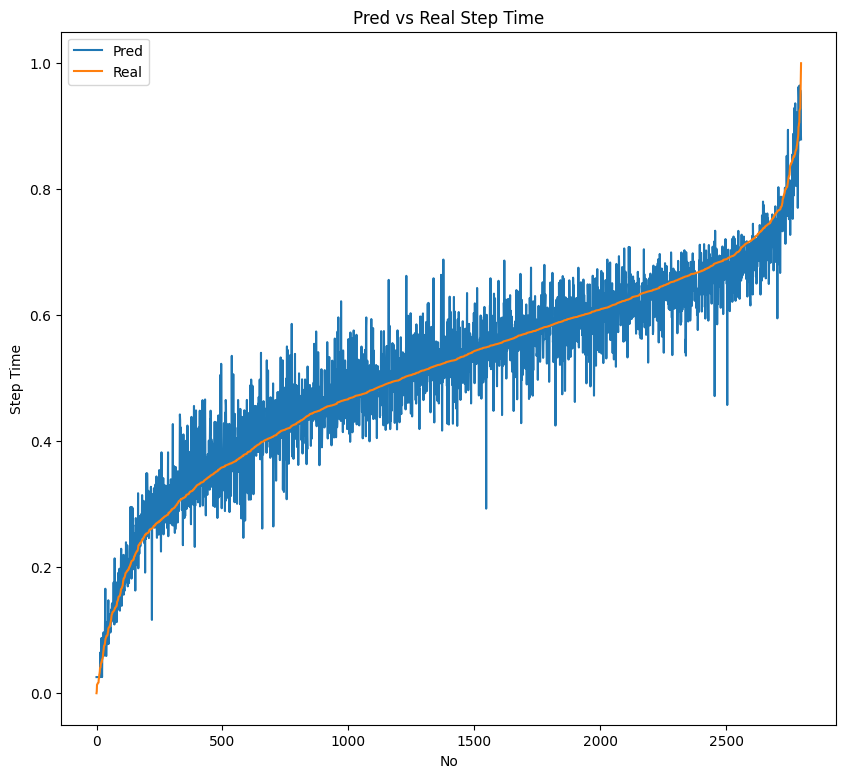

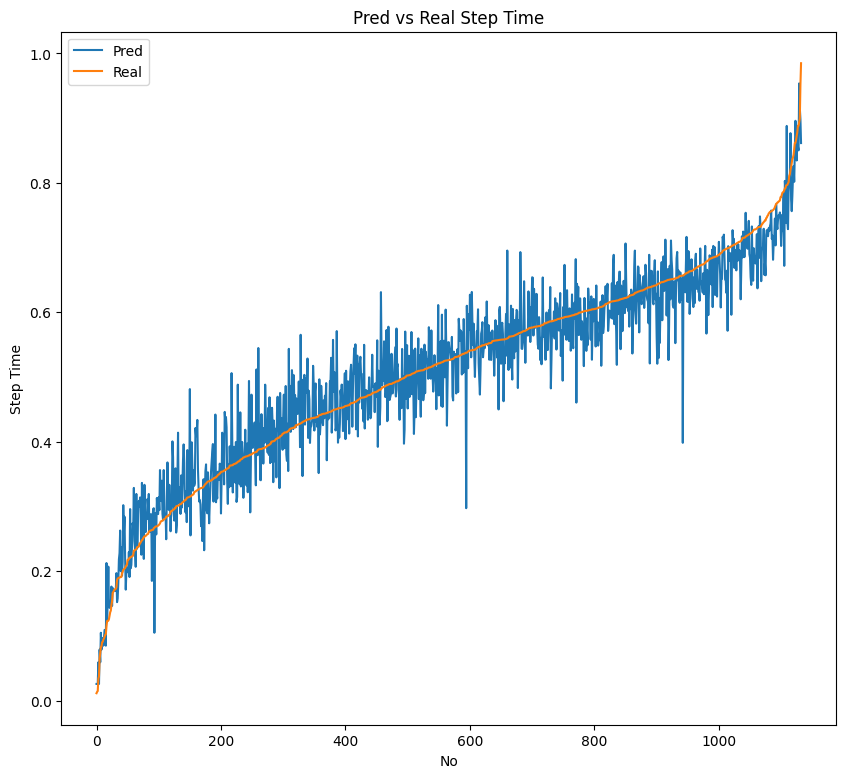

In [13]:
print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# Save the Model

In [14]:
model_structure = model.to_json()
with open("./models/ann_30_1_prestep/structure.json", 'w') as json_file:
    json_file.write(model_structure)

model.save_weights("./models/ann_30_1_prestep/weights.h5")